<a href="https://colab.research.google.com/github/Hsuyeon01/ESAA/blob/main/0527_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

### LinearRegression 클래스 - Ordinary Least Squares

- 입력 파라미터 : 
    - fit_intercept : 불린 값으로, 디폴트는 True, intercept 값을 계산할 것인지 말 것인지를 지정, False로 지정하면 intercept가 사용되지 않고 0으로 지정
    - normalize : 불린 값으로 디폴트는 False, fit_intercept가 False인 경우에는 이 파라미터가 무시됨, True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화
- 속성 : 
    - coef_ : fit() 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성, Shape는 (Target 값 개수, 피처 개수)
    - intercept_ : intercept 값
    
Ordinary Least Squares 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음

- 피처 간의 상관관계가 높은 경우 분산이 매우 커져서 오류에 민감해짐 -> 다중공선성 문제
- 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용, PCA를 통해 차원 축소를 수행하는 것도 고려

### 회귀 평가 지표

- 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심, 오류의 절댓값 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값을 구함

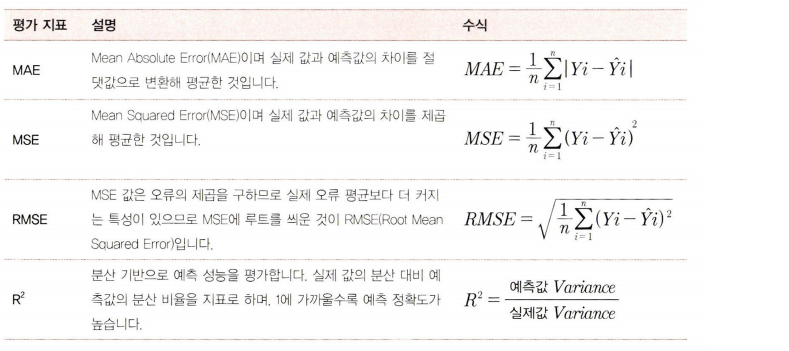

이 외에도 MSE나 RMSE에 로그를 적용한 MSLE, RMSLE도 사용

평가 방법, 사이킷런 평가 지표 API, Scoring 함수 적용 값

- MAE
    - metrics.mean_absolute_error
    - 'neg_mean_absoulte_error'
- MSE
    - metrics.mean_squared_error
    - 'neg_mean_squared_error'
- R-squared
    - metrics.r2_score
    - 'r2'
    
Scoring 함수에 neg_mean_absolute_error를 적용해 음수값을 반환하는 이유 : 사이킷런의 scoring 함수가 score값이 클수록 좋은 평가 결과로 자동 평가하기 때문, 그런데 실제 값과 예측값의 오류 차이를 기반으로 하는 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 모델이라는 의미이므로 보정 필요

### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

1. CRIM : 지역별 범죄 발생률
2. ZN : 25,000평방피트를 초과하는 거주 지역의 비율
3. INDUS : 비상업 지역 넓이 비율 
4. CHAS : 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
5. NOX : 일산화질소 농도
6. RM : 거주할 수 있는 방 개수
7. AGE : 1940년 이전에 건축된 소유 주택의 비율
8. DIS : 5개 주요 고용센터까지의 가중 거리
9. RAD : 고속도로 접근 용이도 
10. TAX : 10,000 달러당 재산세율
11. PTRATIO : 지역의 교사와 학생 수 비율
12. B : 지역의 흑인 거주 비율
13. LSTAT : 하위 계층의 비율
14. MEDV : 본인 소유의 주택 가격(중앙값)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# bosotn 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼을 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 : ', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 :  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


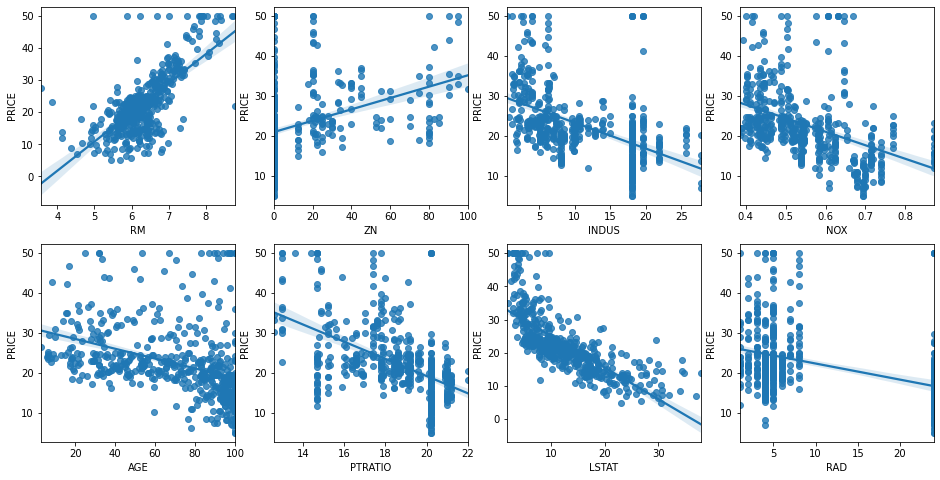

In [ ]:
# 2개의 행과 4개의 열을 가진 subplots를 이용, axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

- RM과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타남
- RM은 양방향의 선형이 가장 큼
- LSTAT는 음 방향의 선형성이 가장 큼
- LSTAT이 적을수록 PRICE가 증가하는 모습이 나타남

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                   random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [ ]:
print('절편값 : ', lr.intercept_)
print('회귀 계수 값 : ', np.round(lr.coef_,1))

절편값 :  40.995595172164585
회귀 계수 값 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [ ]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성, 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index = X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [ ]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE : 5.829
